

# Marketing

Being known for your analytical skills you have been asked to help the Marketing team identify clients who are likely to close their accounts. If these clients are identified early, the Marketing team could reach out to these clients to proactively mitigate their churn.
Your job is to build predictive model that will correctly identify clients who are likely to close their account soon. Use the training data to build your model and use it to make prediction on unlabelled test data. Marketing team will then verify how good the model performance would be if they wanted to use it.
Deadline is short so don’t focus on making your model perfect. It is more important for the marketing team to understand what you are doing so make sure you explain and justify your decisions during the modelling process.





# Presentation

### 1. Import packages

For checking of consistency

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import scipy
import matplotlib
from scipy.optimize import curve_fit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score,precision_score,recall_score,roc_curve,roc_auc_score

In [2]:
for package in [np,pd,matplotlib,sklearn,scipy]:
    print(f"Version of {package.__name__} --> {package.__version__}")

Version of numpy --> 1.22.3
Version of pandas --> 1.4.2
Version of matplotlib --> 3.5.1
Version of sklearn --> 1.1.1
Version of scipy --> 1.7.3


### 2. Let's define some functions that we will use

- *print_info()* gives a nice visual for message outputs
- *fit_non_linear* is used for imputing data which have an exponential, logarithmic, of power-law correlation
- *make_cute_cm* is used for a user-friendly / eye comforting confusion matrix
- *specificity_score* is used to return the specificity of a confusion matrix : $\frac{TN}{all N-s}$ = $\frac{TN}{TN+FP}$

In [3]:
def print_info(message):
    print(f"\n[INFO]: {message} \n")

def fit_non_linear(df_source,x_col,y_col,p0=[0,0],visualize=False,funct='power'):
    
    #create ediatble copy
    df = df_source.copy()
    

    #Apply a global power law fitting missing value padding approach 
    x_fill = df[x_col][df[y_col].notnull() & df[x_col].notnull()]
    y_fill = df[y_col][df[y_col].notnull() & df[x_col].notnull()]


    #fit 

    if funct =='power':
        func = lambda t, alpha1, alpha2: alpha1*(t**alpha2)
    
    if funct=='exp':
        func = lambda t, alpha1, alpha2 : alpha1*np.exp(alpha2*t)
        
    if funct=='ln':
        func = lambda t, alpha1, alpha2 : (-np.log(alpha1) + t)/alpha2 
        
        
            
    popt, pcov = curve_fit(func, x_fill, y_fill, p0)

    if visualize:
        
        y_fit = func(x_fill, *popt)
        
        plt.loglog(x_fill,y_fill,'.',label='data')
        #plt.loglog(x_fill,func(x_fill,*p0),'*',label='initial guess')#
        plt.loglog(x_fill,y_fit,'.',label='fit')
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.legend()
        plt.tight_layout()
        plt.show()        
        

    return func,popt


def make_cute_cm(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        
def specificity_score(y_true,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity            
        

### 3. Explotary data analysis

We wll import the csv file and convert the database into a Geopandas dataframe take a look at what's inside to have a better understanding


#### 3.1 import and summarize

In [31]:
#import data 
df_train = pd.read_csv('data/train.csv')
df_predict = pd.read_csv('data/test.csv')

#drop_duplicates 
df_train.drop_duplicates(inplace=True)
df_predict.drop_duplicates(inplace=True)

#merge 
df_all = pd.concat([df_train,df_predict])

#we will generate a categorical string value ... It will make ploting easy as the database is small ( not for big data) 
df_all['target']= df_all.TARGET.replace({0:"Open Account",1:"Closed Account"})

#summarize data types and not-null values 
df_all.info()

#statistical summary of all the columns  
summary = df_all.describe(include='all').T


#split numerical and categorical columns for further analysis 
cat_cols = list(summary['top'].dropna().index)
num_cols = sorted(list(set(df_all.columns) -  set(summary['top'].dropna().index)))





<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 0 to 1012
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   card_type                 10127 non-null  object 
 2   products_count            10127 non-null  int64  
 3   mnths_with_bank           9952 non-null   float64
 4   mnths_inactive_last_year  10127 non-null  int64  
 5   contacts_last_year        10127 non-null  int64  
 6   education                 9938 non-null   object 
 7   martial_status            10127 non-null  object 
 8   gender                    10026 non-null  object 
 9   earnings_bucket           10127 non-null  object 
 10  age                       10127 non-null  int64  
 11  family_size               10127 non-null  int64  
 12  cc_limit                  10127 non-null  float64
 13  trans_amount              9973 non-null   float64
 14  trans_c

In [5]:
summary

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,10127.0,NaN,NaN,NaN,739177606.333663,36903783.450231,708082083.0,713036770.5,717926358.0,773143533.0,828343083.0
card_type,10127,4,Blue,9436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
products_count,10127.0,NaN,NaN,NaN,3.81258,1.554408,1.0,3.0,4.0,5.0,6.0
mnths_with_bank,9952.0,NaN,NaN,NaN,35.924035,7.99367,13.0,31.0,36.0,40.0,56.0
mnths_inactive_last_year,10127.0,NaN,NaN,NaN,2.341167,1.010622,0.0,2.0,2.0,3.0,6.0
contacts_last_year,10127.0,NaN,NaN,NaN,2.455317,1.106225,0.0,2.0,2.0,3.0,6.0
education,9938,7,Graduate,3075,NaN,NaN,NaN,NaN,NaN,NaN,NaN
martial_status,10127,4,Married,4687,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,10026,2,F,5308,NaN,NaN,NaN,NaN,NaN,NaN,NaN
earnings_bucket,10127,6,Less than $40K,3561,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that the columns **education**, **martial_status**(yes being married is like serving the military :p), **earnings_bucket**, and **trans_amount**  have missing value that we will later need to impute at the feature engineering stage.             

#### 3.2 Visualize the data

##### 3.2.a checking global numerical data

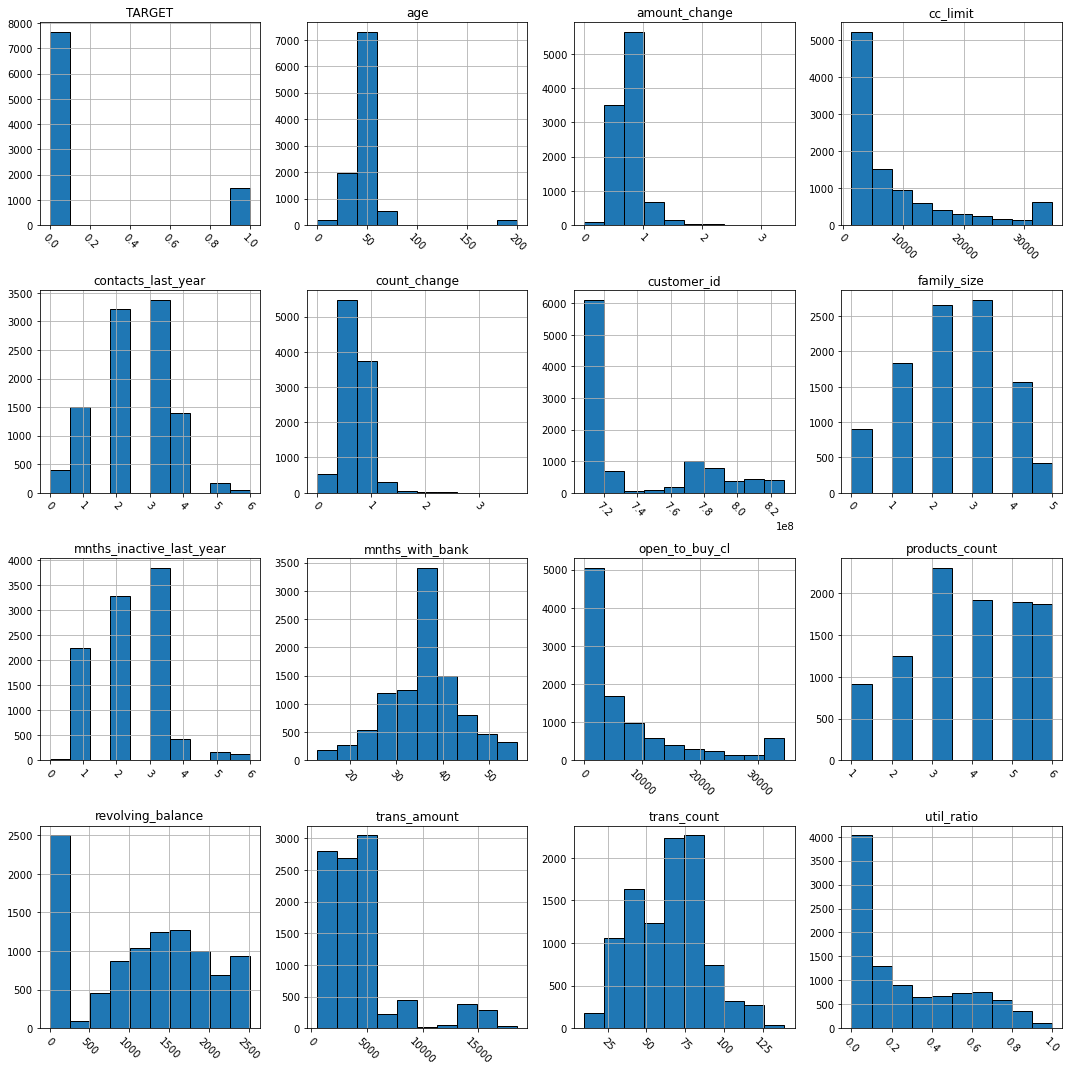

In [6]:
#histograms for numerical columns
df_all[num_cols].hist(figsize=(15,15), xrot=-45,edgecolor='black')
plt.tight_layout()
plt.show()

One curious thing we can spot is the age ... we have values of 0 and 200. We will address this in the feature engineering

##### 3.2.b checking global categorical data

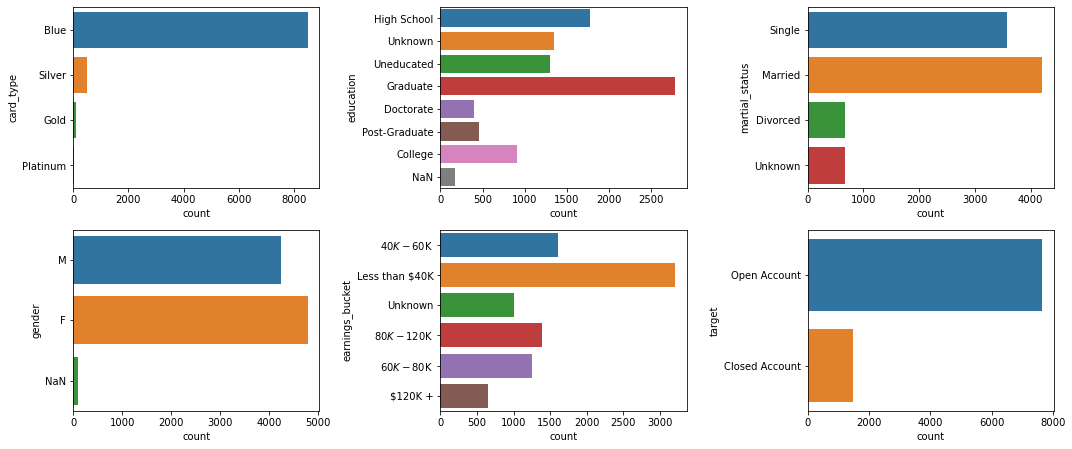

In [7]:
#categorical classes 
plt.figure(figsize=(15,9))
for idx,feature in enumerate(cat_cols):
    plt.subplot(3, 3, idx+1)
    sns.countplot(data=df_all[df_all.target.notnull()].fillna('NaN'), y='{}'.format(feature))
plt.tight_layout()
plt.show()

One interesting thing to note is that we have these **Unknown** tags in many of the columns. I will replace them with NaN and visualize again. It is clear that we have several missing values,  and class imbalance situation but we shall not be concerned about it at this stage since the task required is to show my approach of understanding the data rather than optimizing the algorithm.

In [8]:
df_all.replace({'Unknown':np.nan},inplace=True)

##### 3.2.c Let's check the top combinations of the categorical classes

In [9]:
#checking the catagorical classes [ top demographics ]
df_all[cat_cols+["TARGET"]].value_counts()

card_type  education    martial_status  gender  earnings_bucket  target          TARGET
Blue       Graduate     Married         F       Less than $40K   Open Account    0.0       348
                        Single          F       Less than $40K   Open Account    0.0       276
           High School  Married         F       Less than $40K   Open Account    0.0       209
           Graduate     Married         M       $80K - $120K     Open Account    0.0       172
           High School  Single          F       Less than $40K   Open Account    0.0       165
                                                                                          ... 
Gold       High School  Single          F       $40K - $60K      Open Account    0.0         1
                                                Less than $40K   Open Account    0.0         1
                                        M       $80K - $120K     Closed Account  1.0         1
Silver     Doctorate    Single          M       $60K - $8

##### 3.2.d checking correlations of numerical data via a heatmap

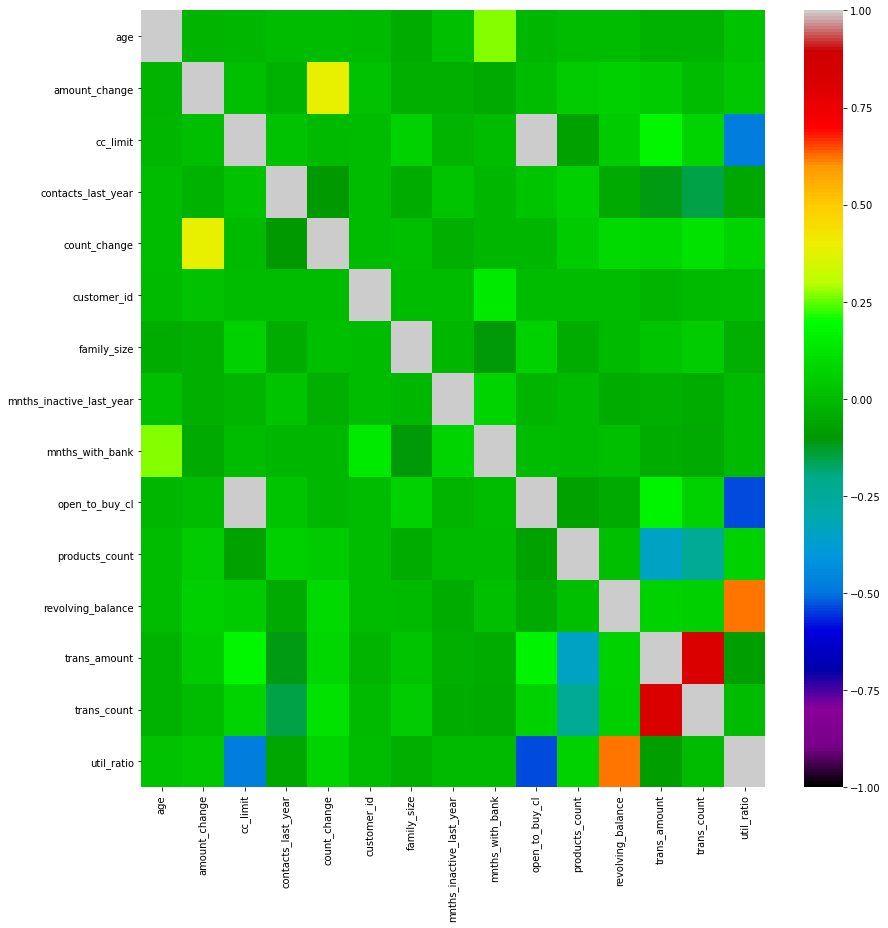

In [10]:
#correlation heat maps 
plt.figure(figsize=(13,13))
sns.heatmap(df_all[num_cols].drop('TARGET',axis=1).corr(),vmin=-1,cmap='nipy_spectral')
plt.tight_layout()
plt.show()

We can find some interesting correlations, two in particular that I would like to investigate are the correlation betweeing the *cc_limit* vs the *util_ratio*. The second one is the correlation between the transaction amount and the count. 

##### 3.2.e Digging deeped in the numerical data

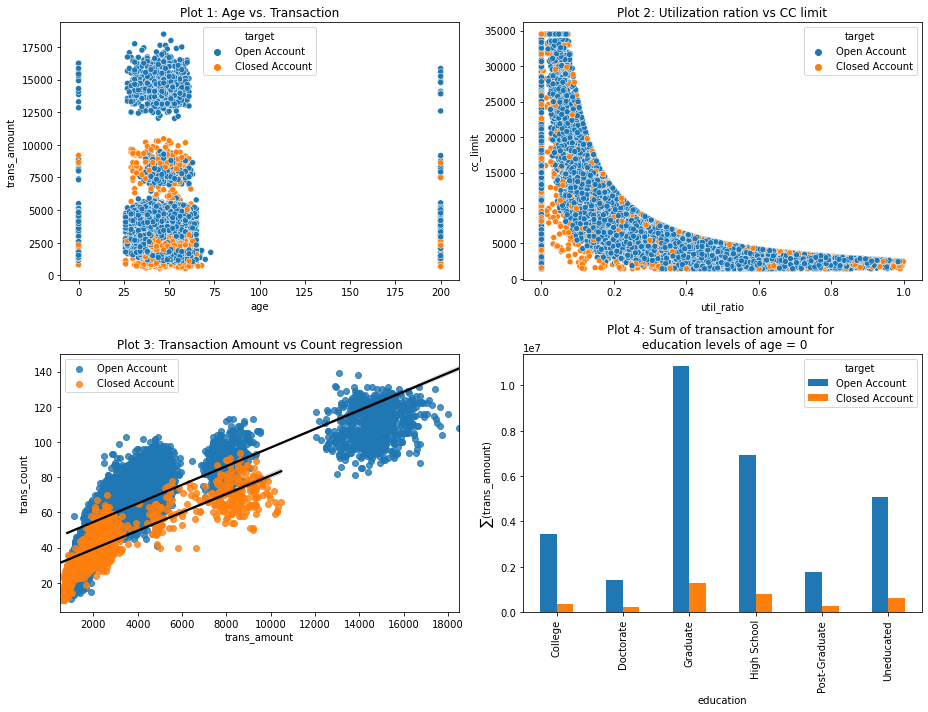

In [11]:
#show some individuual values with high correlation 
plt.figure(figsize=(13,10))

plt.subplot(2, 2, 1)
sns.scatterplot(x='age',y='trans_amount',hue='target',data=df_all)
plt.title(label ='Plot 1: Age vs. Transaction')

plt.subplot(2, 2, 2)
sns.scatterplot(x='util_ratio',y='cc_limit',hue='target',data=df_all)
plt.title(label ='Plot 2: Utilization ration vs CC limit')

ax1=plt.subplot(2, 2, 3)
sns.regplot(data=df_all.query('TARGET==0'), x="trans_amount", y="trans_count",ax=ax1,line_kws={"color": "black"},label= "Open Account")
sns.regplot(data=df_all.query('TARGET==1'), x="trans_amount", y="trans_count",ax=ax1,line_kws={"color": "black"},label= "Closed Account")
plt.title(label ='Plot 3: Transaction Amount vs Count regression')
plt.legend()
ax=plt.subplot(2, 2, 4)
df_all.groupby(["education",'target'])['trans_amount'].sum().unstack().reset_index()\
            .plot(kind='bar',x='education',y=['Open Account','Closed Account'],
                  title='Plot 4: Sum of transaction amount for \n education levels of age = 0', 
                  ax=ax,
                  ylabel=r'$\sum$(trans_amount)')

plt.tight_layout()
plt.show()


- Plot 1: One curious thing we discover the age have been generated and clearly cuttoff between 25 and 75 ... 0 and 200 were generated as outliers. It's an audition examination ... or maybe it's the age allowed for having a bank account


- Plot 2: The hyperbolic correlation $cc\_limit=\frac{1}{x}$ indicates that the utilization ratio as the average card utilization and it is correlated to the cc_limit. The higher the limit the more the utilization.  


- Plot 3: Here we find a very interesting correlations and segmentation between the behaviour of the churned and the loyal customer. In addition there seems to be 3 groups of spenders that we can later use to generate a new categorical class and improve the model


- Plot 4: When analyzing the the age = 0, a question popped in my mind: Is it a glitch or randomness,on purpose which describes the accounts held by guardians for there minor children as sort of a college fund or savings accout. By looking at the transaction and the education group we people at different levels of education which means that these zeros required to be investigated. 

### 4. Feature engineering

Now that we discovered crucial information about our data, we can commence to apply edits to be able to apply clean-up and transformations to be able to use in for classifiying further churn on newer data. 



#### 4.1 Fill the missing values

As the famous saying goes ... Garbage in, Garbage out. One of the most time spent of a data science project is feature engineering, where after acuisition it will require alot of work to improve the data. That is why I'm giving a strong emphasis in this notebook.

In [12]:
#Age 
#Lucile Randon of France is the oldest person alive 118 years
ages = df_all.groupby('education',as_index=False).agg(age=("age","mean"),age_std=("age","std"))
ages

,education,age,age_std
0,College,47.883534,23.019076
1,Doctorate,48.256757,20.387373
2,Graduate,48.763577,23.790475
3,High School,48.083122,22.639453
4,Post-Graduate,46.799205,20.899242
5,Uneducated,47.940288,22.234141


Seems like the number were randomly gen by mean of 45 and std of 10 ... while imposing the 200 and 0. So I will also remove them 

In [13]:
df_all = df_all.query("age > 0 & age <= 119").copy()

In [14]:
#There should always a log in sytems about when data was registered to the database
df_all.mnths_with_bank.fillna(0,inplace=True)


#If there is no transactions then we can replace it with a zero  
df_all.loc[(df_all.trans_amount.isna() & df_all.trans_count.isna()),'trans_amount'] = 0 
df_all.loc[(df_all.trans_amount.isna() & df_all.trans_count.isna()),'trans_count'] = 0 



From the visualization above we noticed there is correlation between the transaction amount and counts. we can use the correlation to impute the missing data. I will apply exponential and logartihmic functuions inversly. 

For *trans_count* we will use $y= C_{1}e^{C_{2}x}$, and we will use the fitted parameters for the inverse Missing values for *trans_amount* we will use $y = \frac{ln(x)-ln(C_{1})}{C_2}$


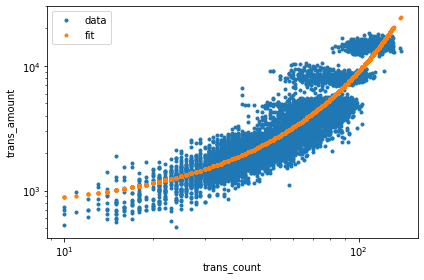

In [15]:
# imputing trans_count
func,popt = fit_non_linear(df_all[['trans_amount','trans_count']],
                        x_col='trans_count', 
                        y_col='trans_amount',
                        visualize=(True),
                        funct='exp')

plt.show()

df_all['trans_amount']= np.where(df_all['trans_amount'].isna(),func(df_all['trans_count'], *popt),df_all['trans_amount'])


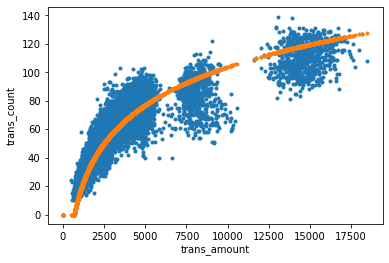

In [16]:

#inverse of the function (trans_amount)
func_inv = lambda t, alpha1, alpha2 : (-np.log(alpha1) + np.log(t))/(alpha2)
df_all.loc[df_all.trans_amount==0,'trans_amount'] = 0.01
df_all.loc[df_all.trans_amount==0,'trans_count'] = 0.01
df_all['trans_count']= np.where(df_all['trans_count'].isna(),func_inv(df_all['trans_amount'], *popt),df_all['trans_count'])
df_all.loc[df_all['trans_count']<0,'trans_count'] = 0

plt.plot(df_all['trans_amount'],df_all['trans_count'],'.',label='data')
viz = func_inv(df_all['trans_amount'],*popt)
viz.loc[viz<0] = 0
plt.plot(df_all['trans_amount'],viz,'.')
plt.xlabel("trans_amount")
plt.ylabel("trans_count")
plt.show()



#### 4.2 Generate Machine learning ecodable columns 

We noticed from the transactions there is sort of 3 sets of classes

- High spenders
- Medium spenders
- Low spenders

So let's create some new features

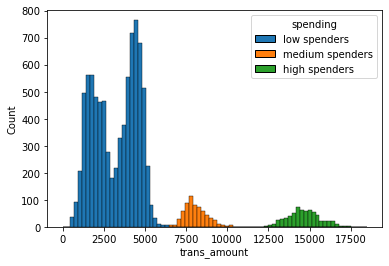

In [17]:
df_all['spending'] = np.nan
df_all.loc[(df_all.trans_amount<= 6500),'spending'] = 'low spenders'
df_all.loc[(df_all.trans_amount> 6500)&((df_all.trans_amount<= 11000)),'spending'] = 'medium spenders'
df_all.loc[df_all.trans_amount> 11000,'spending'] = 'high spenders'


sns.histplot(data=df_all,x='trans_amount',hue='spending',alpha=1)
plt.show()


Let's convert all the categorical into numerical data and even the NaN values to maintain the data will be converted into a category. Since the database is small removing them is not a smart move. 

*Note*: Further analysis for class imbalances and quality of data 
- Oversampling and augumentation of data 
- Quality check of data based on common sense and industry knowledge 
- Since the database is small, so we analyzed all the data together. They can always have different distributions and problems which require to be handled. Especially if the data we are to predict later on might come from another resource, client, server, etc ... 

But it's out of the scope 


In [18]:
#create set of encoders for each variable 
cat_cols = [ 'card_type',
             'education',
             'martial_status',
             'gender',
             'earnings_bucket',
             'spending']

encoder_dict = { i : LabelEncoder().fit(df_all[i]) for i in cat_cols+['spending'] } 
""" Note that the NaNs are converted into a labeled class """ 


#encode both training and testing sets 
x_all = df_all.copy()
for col in cat_cols:
    x_all[col] = encoder_dict[col].transform(x_all[col])

#split the features and labels.
x_all.drop(['customer_id','TARGET','target'],axis=1,inplace=True)

#split data into training (with labels) and predictions (without labels)
x_obs = x_all[df_all.TARGET.notnull()] 
x_pred = x_all[df_all.TARGET.isna()] 

y= df_all.TARGET[df_all.TARGET.notnull()].to_numpy()


#### 4.3 Dimesionality reduction
Sometimes the database can have a huge number of columns and would require to squeeze it down a bit. PCA and T-SNE come in handy for this case. It can also help us visualize certain classes/clusters. For the sake of analysis of will include it in the feature engineering section.

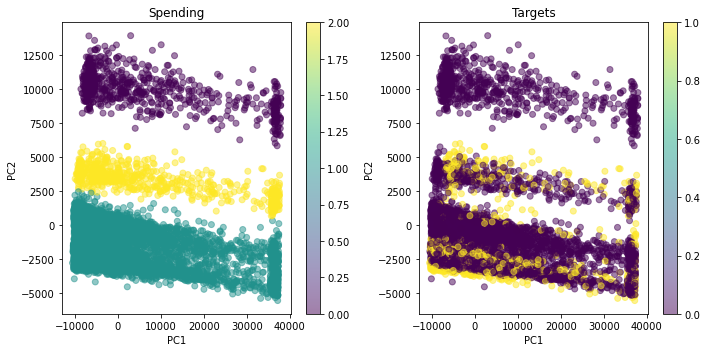

In [19]:
#PCA 
pca = PCA()
x_pca = pca.fit_transform(x_obs)
df_pca = pd.DataFrame(x_pca,columns = [f"PC{i}" for i in range(1,x_pca.shape[1]+1)])
df_pca['TARGET'] = y 

#spending
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.scatter(df_pca.PC1,df_pca.PC2,c=x_obs.spending,alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Spending")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(df_pca.PC1,df_pca.PC2,c=y,alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Targets")
plt.colorbar()

plt.tight_layout()
plt.show()



In [20]:
X_emb = TSNE(n_components=2, learning_rate='auto', init='random', perplexity = 10 ).fit_transform(x_pca)
df_emb = pd.DataFrame(X_emb,columns = [f"PC{i}" for i in range(1,X_emb.shape[1]+1)])


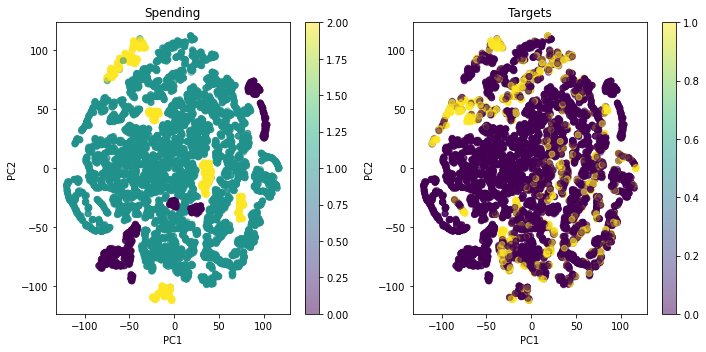

In [21]:
#spending
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.scatter(df_emb.PC1,df_emb.PC2,c=x_obs.spending,alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Spending")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(df_emb.PC1,df_emb.PC2,c=y,alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Targets")
plt.colorbar()

plt.tight_layout()
plt.show()

### 5.Classification and Predictions

To run this binary classifier is it benificial to run several models and choose the optimal one. Most of the times some algorithms can work better than others. Ensemble models tend to have better results, especially when regulization techniques are applied to prevent fitting the noise. I will test 3 algorithms: 

1. Logistic regression with L2 regularization
2. Random Forrest Classifier 
3. Gradient Boosting Classifer 





#### 5.1 Preparing the pipeline 

In [22]:
#create a pipeline for analysis 
pipelines = {
        
       'l2': make_pipeline(StandardScaler(), 
             LogisticRegression(penalty='l2', random_state=123)),
       'rf': make_pipeline(
             RandomForestClassifier(random_state=123)),
       'gb': make_pipeline(
             GradientBoostingClassifier(random_state=123))
            }


#define the hyperparameters 
l2_hyperparameters = {'logisticregression__C' : 
                       [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 
                        1, 5, 10, 50, 100, 500, 1000]
                     }

rf_hyperparameters = {
    'randomforestclassifier__n_estimators' : [100, 200],
    'randomforestclassifier__max_features' : ['sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf' : [1, 3, 5, 10]
    }    
    
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators' : [100, 200],
    'gradientboostingclassifier__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth' : [1, 3, 5]
}


#summarize the hyperparameters 
hyperparameters = {
    'l2' : l2_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
    }

#### 5.2 Running the pipeline and saving all the models in a cache

We will split the data to a 20% test and 80% train

In [23]:
#Applying different models for predicting churn 
x_train, x_test, y_train, y_test = train_test_split(x_obs, y, test_size=0.2, random_state=1234, stratify=y)

import time

#apply training on all models using a grod search with 10 folds 
fitted_models = {}
for name, pipeline in pipelines.items():
    start = time.time()
    
    try:
        model = GridSearchCV(pipeline, 
                             hyperparameters[name], 
                             cv=10, 
                             n_jobs=-1)
        model.fit(x_train, y_train)
        fitted_models[name] = model
        end = time.time()
        total = (end - start)/60
        print_info(f"Model: {name} --> run time : {total:.2f} mins")

        
    except:
        end = time.time()
        total = (end - start)/60

        print_info(f"Model: {name} --> run time : {total:.2f} mins")
        
    
    


[INFO]: Model: l2 --> run time : 0.11 mins 


[INFO]: Model: rf --> run time : 0.40 mins 


[INFO]: Model: gb --> run time : 0.80 mins 



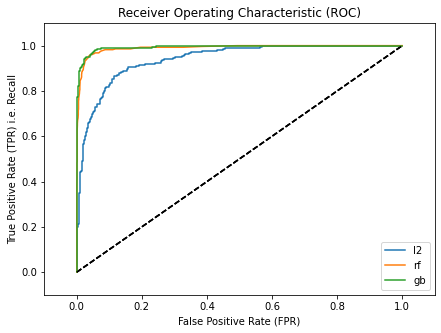

In [24]:
#modeling summary 
model_summary = { 'model':[],
                  'best_score':[],
                  'accuracy':[],
                  'precision':[],
                  'recall':[],
                  'specificity':[],
                  'f1_score':[],
                  'AUROC':[]
                  }

plt.figure(figsize=(7,5))

for name, model in fitted_models.items():

    y_pred = fitted_models[name].predict(x_test)

    
    model_summary['model'].append(name)
    model_summary['best_score'].append(model.best_score_)
    model_summary['accuracy'].append(accuracy_score(y_test, y_pred))
    model_summary['precision'].append(precision_score(y_test, y_pred))
    model_summary['recall'].append(recall_score(y_test, y_pred))
    model_summary['specificity'].append(specificity_score(y_test, y_pred))
    model_summary['f1_score'].append(f1_score(y_test, y_pred))
    model_summary['AUROC'].append(roc_auc_score(y_test, y_pred))
    
    
    # obtain prediction probabilities
    pred = fitted_models[name].predict_proba(x_test)

    #the index =1 is the positivity probability
    pred = [p[1] for p in pred]
    
    # plot ROC
    fpr, tpr, thresholds = roc_curve(y_test, pred) 
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(fpr, tpr, label=name)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate (TPR) i.e. Recall')
    plt.xlabel('False Positive Rate (FPR)')
    
plt.show()




In [26]:
model_summary = pd.DataFrame(model_summary)
model_summary

,model,best_score,accuracy,precision,recall,specificity,f1_score,AUROC
0,l2,0.905817,0.912969,0.789238,0.624113,0.968157,0.697030,0.796135
1,rf,0.961304,0.967008,0.917910,0.872340,0.985095,0.894545,0.928718
2,gb,0.969982,0.974403,0.950570,0.886525,0.991192,0.917431,0.938859


We can see that on every from Gradient boosting is the top one in this case ... Hence we will use it for further predictions. Although we are interested more in clients who are closing the account ... So optimizing for improving the Recall(a.k.a sensitivity) is very important as it present the rate of positive prediction: Recall = $\frac{TP}{TP+FN}$. 

We also see the area under the Receiver opearting curve (AUROC) gives us higher positive value for gb hence it is better in classfiying clients who will churn (TARGET=1).   

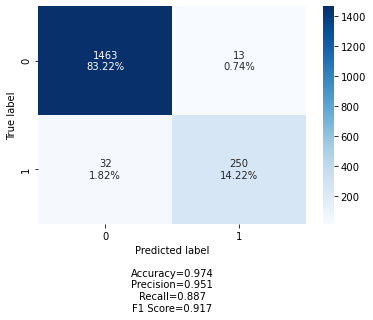

In [27]:
#gb       
y_pred = fitted_models['gb'].predict(x_test)
cm = confusion_matrix(y_test, y_pred)
make_cute_cm(cm)

In [28]:
#classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1476
         1.0       0.95      0.89      0.92       282

    accuracy                           0.97      1758
   macro avg       0.96      0.94      0.95      1758
weighted avg       0.97      0.97      0.97      1758



We can see that there is still room for improving the recall for Gradient boosting

##### Plus action 

For the sake of intrigue ... let's have another look at the features of the Random Forrest since it has very close results to that of the gradient boosting. 

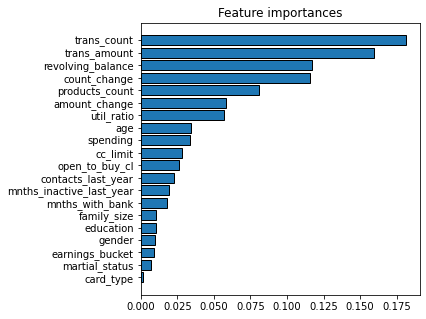

In [29]:
coef = fitted_models['rf'].best_estimator_.steps[0][1].feature_importances_
idx = np.argsort(-coef)

cols = range(x_train.shape[1])
imps = coef[idx][:x_train.shape[1]]

plt.figure(figsize=(5,5))
ax = plt.subplot()
plt.barh(cols, imps, edgecolor='black')
ax.set_yticks(cols)
ax.set_yticklabels(x_obs.columns[idx])
plt.title("Feature importances")
plt.gca().invert_yaxis()
plt.show()

yet again we see that the amount of money spent is giving us an intuition behind the churning of the clients ... If they are not spenders, then it is a sign that they will be leaving

### 5.2 Running the predictions 

In [30]:

#Let's now predict the unlabeled ones
y_unknown = fitted_models['gb'].predict(x_pred)
print(pd.Series(y_unknown).value_counts())

0.0    823
1.0    142
dtype: int64


### 6. Conclusions



       
### 6. Conclusions

For this audition we have analyzed the dataset of the churn for clients regarding bank accounts. In section 1, we imported the required packages and identified the versions required. In section 2, we presented some required functions which improved the quality of this notebook. In  section 3, for the EDA phase, we summarized and visualized the datasets in different approaches and detected some slight anomalies such as the issues with the ages. We also discovered that there are missing values and class imbalance. In section 4 we applied feature engineering to transpose and generate new features specifically for expenditures. Also, some preliminary dimensionality reduction techniques were applied to find clusters using unsupervised methods but they seem to show some unintuitive results hence no further discussion was involved.  In section 5, we implemented 3 classification algorithms which were : Regularized logistic regression (l2), and other ensemble models which were the Random Forests(rf) and the Gradient Boosting(gb). We discovered that rf and gb were the top performing models based on the recall and the AUROC.    

Finally, from rf we discovered that the spent money by clients can be a good indicator for their behaviour of keeping their accounts, but does not necessarily mean they will close it since other features had weights associated with it. Some people may leave the country and keep their accounts and there can be many psychological/sociological explanations for behaviour which we can discover with the help of industry experts.

Some propositions for the future improvements are working on the input data to improve the datasets and gather more of it to have a balanced target dataset. Increase the global quantity of the dataset to make sure no over-fitting has occurred. Which is a very important test to do. A concept that I did not address here. Modern practices require 3 dataset 98% training, 1% testing, and 1% control sets. The control set should have a different quality since it might come from other resources . For our case the last prediction set did not have any targets. In addition, in this notebook, I did not individually study the datasets (observation-train-test vs the prediction, with and without targets respectively). Each one can have a different set of impurities which should be addressed. In addition, for the data imputation of the missing values, we encoded the NaN values with new numerical labels. Further research should be applied to fill in these gaps because a degeneracy will be generated between those values and can distort the results. Industry knowledge can help in more accurate imputations. For example, we analyzed the ages versus education and noticed that the ages were created for the purpose of simulation of this audition. In real life, the mean ages and the education levels should be linearly correlated especially at the school and college level and should have a heteroskedastic behaviour as we go towards higher education.    

Finally, as the recall of the gb and rf algorithms is still around 88% this can give us hope to improve it. We can also apply more hyperparameter tuning and implementation of other algorithms to see which can perform even better to increase the recall because we are interested in who is closing the accounts.   


##### Closer
Thank you so much for this opportunity, and I hope with this work I will be able to show my method of thinking. 

Looking forward to hearing from you. 

Cheers! 